# Project Two Code 

In [2]:
import numpy as np
import nltk
from nltk.corpus import stopwords
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from fuzzywuzzy import fuzz
from sklearn.linear_model import LogisticRegression
from transformers import pipeline

C:\Users\Nadya\anaconda3\envs\ECON1680\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Web Scraping NYT Articles Using NYT API 

In [2]:
import requests as req
import time
API_KEY='9kiWZKsGFtTkcTD4yYkyxWAKehiTKkzR' # your API key

In [3]:
import calendar

# Create an empty list to store articles
articles2 = []

# Loop through every month from Jan 2020 to Feb 2024
for year in range(2020, 2024):
    for month in range(1, 13):
        # Calculate the number of days in the current month
        num_days = calendar.monthrange(year, month)[1]

        # Construct the begin_date and end_date parameters for the query
        begin_date = f"{year:04d}-{month:02d}-01"
        end_date = f"{year:04d}-{month:02d}-{num_days:02d}"

        # Loop through 5 pages (max 10 results per page, hence 50 articles)
        for i in range(5):
            # Sleep to avoid exceeding the API rate limit
            time.sleep(10)
            try:
                # Construct the URL
                url = f'https://api.nytimes.com/svc/search/v2/articlesearch.json?q=artificial+intelligence&api-key={API_KEY}&sort=relevance&begin_date={begin_date}&end_date={end_date}&page={i+1}'

                # Make the request and get the response
                response = req.get(url).json()
                # Extract relevant information from the response and append to articles list
                docs = response['response']['docs']
                for doc in docs:
                    filteredDoc = {}
                    filteredDoc['title'] = doc['headline']['main']
                    filteredDoc['abstract'] = doc['abstract']
                    filteredDoc['paragraph'] = doc['lead_paragraph']
                    filteredDoc['date'] = f"{year}-{month:02d}"
                    articles2.append(filteredDoc)
                
                
            except KeyError as e:
                print(f"No response while processing page {i+1} for {begin_date} - {end_date}: {e}")


No response while processing page 3 for 2020-02-01 - 2020-02-29: 'response'
No response while processing page 4 for 2020-04-01 - 2020-04-30: 'response'
No response while processing page 5 for 2020-07-01 - 2020-07-31: 'response'
No response while processing page 1 for 2020-11-01 - 2020-11-30: 'response'
No response while processing page 2 for 2021-01-01 - 2021-01-31: 'response'
No response while processing page 3 for 2021-04-01 - 2021-04-30: 'response'
No response while processing page 4 for 2021-06-01 - 2021-06-30: 'response'
No response while processing page 5 for 2021-09-01 - 2021-09-30: 'response'
No response while processing page 1 for 2022-01-01 - 2022-01-31: 'response'
No response while processing page 2 for 2022-03-01 - 2022-03-31: 'response'
No response while processing page 3 for 2022-06-01 - 2022-06-30: 'response'
No response while processing page 4 for 2022-08-01 - 2022-08-31: 'response'
No response while processing page 5 for 2022-11-01 - 2022-11-30: 'response'
No response 

In [4]:
nyt_ai2 = pd.DataFrame(data=articles2)

In [5]:
nyt_ai2.shape

(1370, 4)

#### Note: 1370 articles in total means an average of ~28-29 articles scraped per month 

In [7]:
nyt_ai2.to_csv('r2_scraped_nyt.csv')

## Text Upload

In [3]:
nyt_data = pd.read_csv('r2_scraped_nyt.csv')

In [4]:
nyt_data.drop(columns=['Unnamed: 0'])

,title,abstract,paragraph,date
0,Soon a Robot Will Be Writing This Headline,"In “A World Without Work,” the economist Danie...","A WORLD WITHOUT WORK Technology, Automation, a...",2020-01
1,A.I. Comes to the Operating Room,Images made by lasers and read by computers ca...,Brain surgeons are bringing artificial intelli...,2020-01
2,Confessions of a Dating Profile,"My boss’s demands were very, very persuasive, ...","My boss’s demands were very, very persuasive, ...",2020-01
3,"Lesson of the Day: ‘The Machines Are Learning,...","In this lesson, students will learn about how ...","Featured Article: “The Machines Are Learning, ...",2020-01
4,Facebook Says It Will Ban ‘Deepfakes’,The company said it would remove videos altere...,WASHINGTON — Facebook says it will ban videos ...,2020-01
...,...,...,...,...
1365,Cities Foster Serendipity. But Can They Do It ...,Revisiting a theory about chance collisions an...,There is a thing that happens in cities — that...,2023-10
1366,Allied Spy Chiefs Warn of Chinese Espionage Ta...,F.B.I. officials say more than half of Chinese...,The United States and its allies vowed this we...,2023-10
1367,Researchers Say Guardrails Built Around A.I. S...,OpenAI now lets outsiders tweak what its chatb...,Before it released the A.I. chatbot ChatGPT la...,2023-10
1368,An Industry Insider Drives an Open Alternative...,"The nonprofit Allen Institute for AI, led by a...",Ali Farhadi is no tech rebel.,2023-10


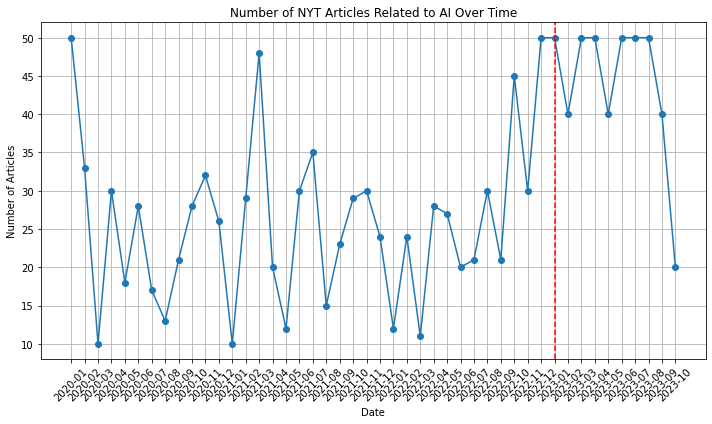

In [45]:
# Count the number of articles for each date
article_counts_by_date = nyt_data['date'].value_counts().sort_index()

# Plot the number of articles over time
plt.figure(figsize=(10, 6))
plt.plot(article_counts_by_date.index, article_counts_by_date.values, marker='o', linestyle='-')
plt.title('Number of NYT Articles Related to AI Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
# Draw a horizontal line at date '2023-01'
plt.axvline(x='2023-01', color='r', linestyle='--', label='2023-01')
plt.show()

In [5]:
layoffs_data = pd.read_csv('layoffs_data(3).csv')

In [9]:
layoffs_data.head()

,Company,Location_HQ,Industry,Percentage,Date,Source,Funds_Raised,Stage,Date_Added,Country,Laid_Off_Count,List_of_Employees_Laid_Off
0,Fisker,Los Angeles,Transportation,0.15,2024-02-29,https://techcrunch.com/2024/02/29/fisker-layof...,1700.0,Post-IPO,2024-02-29 23:35:20,United States,NaN,Unknown
1,Electronic Arts,SF Bay Area,Consumer,0.05,2024-02-28,https://www.cnbc.com/2024/02/28/ea-layoffs-com...,2.0,Post-IPO,2024-02-29 00:45:00,United States,670.0,Unknown
2,Vacasa,Portland,Travel,0.05,2024-02-28,https://www.oregonlive.com/business/2024/02/po...,834.0,Post-IPO,2024-02-29 17:22:37,United States,320.0,Unknown
3,Treasury Prime,SF Bay Area,Finance,0.40,2024-02-28,https://www.bankingdive.com/news/treasury-prim...,71.0,Series C,2024-02-29 00:48:03,United States,40.0,Unknown
4,Motional,Boston,Transportation,0.05,2024-02-28,https://techcrunch.com/2024/02/28/hyundai-back...,NaN,Unknown,2024-02-28 18:50:58,United States,NaN,Unknown


In [43]:
# Convert 'date' column to datetime
layoffs_data['Date'] = pd.to_datetime(layoffs_data['Date'])

# Convert 'date' column to 'YYYY-MM' format
layoffs_data['Date'] = layoffs_data['Date'].dt.strftime('%Y-%m')

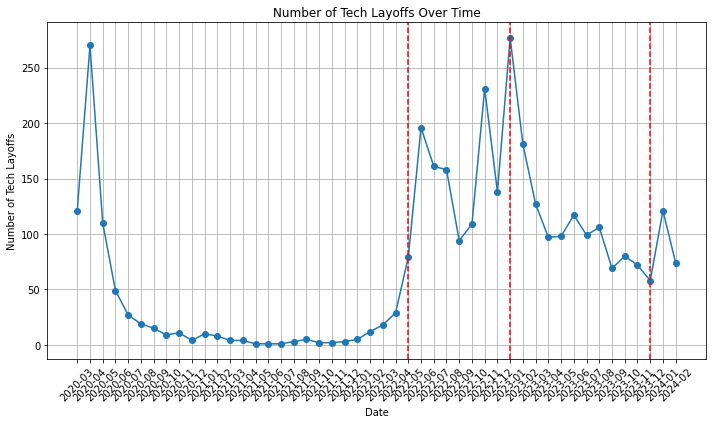

In [56]:
# Count the number of layoffs for each date
layoffs_counts_by_date = layoffs_data['Date'].value_counts().sort_index()
# Plot the number of layoffs over time
plt.figure(figsize=(10, 6))
plt.plot(layoffs_counts_by_date.index, layoffs_counts_by_date.values, marker='o', linestyle='-')
plt.title('Number of Tech Layoffs Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Tech Layoffs')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
# Draw a horizontal line at date '2023-01'
plt.axvline(x='2023-01', color='r', linestyle='--', label='2023-01')
plt.axvline(x='2022-05', color='r', linestyle='--', label='2023-01')
plt.axvline(x='2023-12', color='r', linestyle='--', label='2023-11')
plt.show()

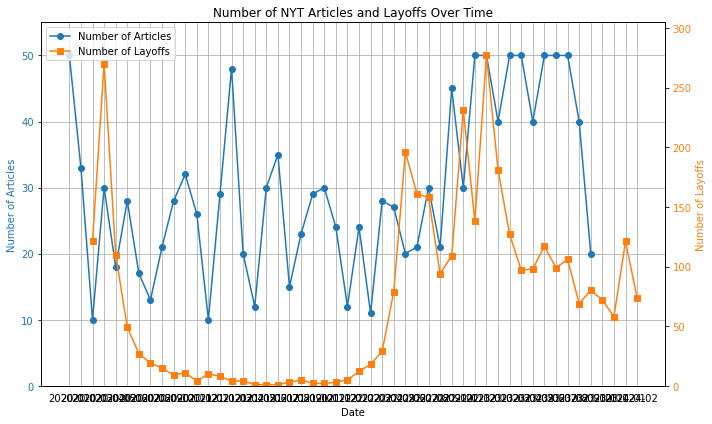

In [57]:
# Count the number of layoffs for each date
layoffs_counts_by_date = layoffs_data['Date'].value_counts().sort_index()

# Plot number of articles over time
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Articles', color=color)
ax1.plot(article_counts_by_date.index, article_counts_by_date.values, color=color, marker='o', linestyle='-', label='Number of Articles')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

# Create a twin Axes sharing the same x-axis
ax2 = ax1.twinx()

color = 'tab:orange'
ax2.set_ylabel('Number of Layoffs', color=color)
ax2.plot(layoffs_counts_by_date.index, layoffs_counts_by_date.values, color=color, marker='s', linestyle='-', label='Number of Layoffs')
ax2.tick_params(axis='y', labelcolor=color)

# Set y-axis limits for number of articles plot
max_articles = article_counts_by_date.max()
scaling_factor_articles = 1.1  # Adjust the scaling factor as needed
ax1.set_ylim([0, max_articles * scaling_factor_articles])

# Set y-axis limits for number of layoffs plot
max_layoffs = layoffs_counts_by_date.max()
scaling_factor_layoffs = 1.1  # Adjust the scaling factor as needed
ax2.set_ylim([0, max_layoffs * scaling_factor_layoffs])

# Set x-axis labels for the bottom plot (articles)
ax2.set_xlabel('Date')
# Hide x-axis labels for the top plot (layoffs)
ax1.tick_params(axis='x', which='both', bottom=False, top=False)

# Add legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('Number of NYT Articles and Layoffs Over Time')
plt.tight_layout()
plt.show()


## Preliminary Sentiment Analysis 

### Using Transfer-Learning Methods

#### Using Default DistilBERT Model

In [58]:
# Initiate a pipeline with the default sentiment analysis model
sentiment_pipeline = pipeline("sentiment-analysis")

# Convert paragraphs to strings
nyt_data['paragraph'] = nyt_data['paragraph'].astype(str)

# Function to calculate sentiment score
def calculate_sentiment_score(paragraph):
    # Perform sentiment analysis on the paragraph
    sentiment = sentiment_pipeline(paragraph)[0]
    
    # If sentiment is negative, return -1 * score
    if sentiment['label'] == 'NEGATIVE':
        return -1 * sentiment['score']
    # If sentiment is positive, return +1 * score
    elif sentiment['label'] == 'POSITIVE':
        return sentiment['score']
    else:
        return None

# Apply the function to each row and create a new column 'sentiment_score'
nyt_data['distilbert_sentiment_score'] = nyt_data['paragraph'].apply(calculate_sentiment_score)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


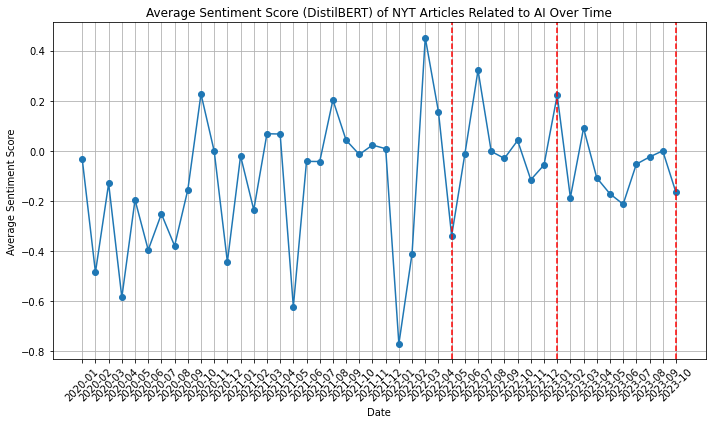

In [60]:
# Group by date and calculate average sentiment score
average_sentiment_by_date = nyt_data.groupby('date')['distilbert_sentiment_score'].mean()

# Plot the time-wise graph
plt.figure(figsize=(10, 6))
plt.plot(average_sentiment_by_date.index, average_sentiment_by_date.values, marker='o', linestyle='-')
plt.title('Average Sentiment Score (DistilBERT) of NYT Articles Related to AI Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
# Draw a horizontal line at date '2023-01'
plt.axvline(x='2023-01', color='r', linestyle='--', label='2023-01')
plt.axvline(x='2022-05', color='r', linestyle='--', label='2023-01')
plt.axvline(x='2023-10', color='r', linestyle='--', label='2023-11')
plt.show()

In [62]:
# Generate a dummy variable for positive/ negative 
nyt_data['distilbert_sentiment_dummy'] = nyt_data['distilbert_sentiment_score'].apply(lambda x: 1 if x > 0 else 0)

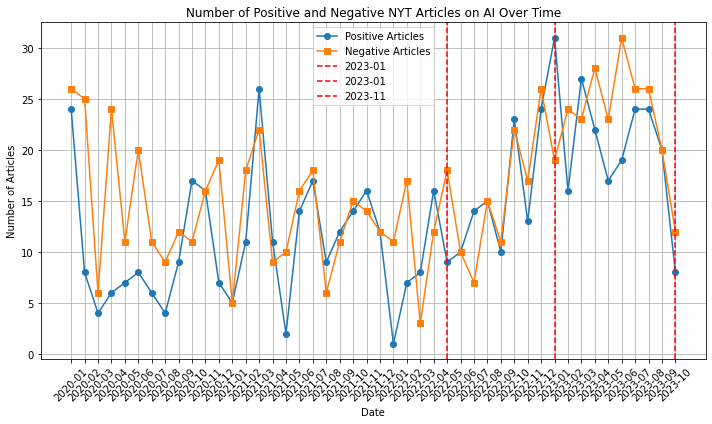

In [64]:
# Graph number of positive articles over time AND number of negative articles over time (two lines)
positive_articles = nyt_data[nyt_data['distilbert_sentiment_dummy'] == 1].groupby('date').size()
negative_articles = nyt_data[nyt_data['distilbert_sentiment_dummy'] == 0].groupby('date').size()

plt.figure(figsize=(10, 6))
plt.plot(positive_articles.index, positive_articles.values, label='Positive Articles', marker='o')
plt.plot(negative_articles.index, negative_articles.values, label='Negative Articles', marker='s')

plt.axvline(x='2023-01', color='r', linestyle='--', label='2023-01')
plt.axvline(x='2022-05', color='r', linestyle='--', label='2023-01')
plt.axvline(x='2023-10', color='r', linestyle='--', label='2023-11')

plt.title('Number of Positive and Negative NYT Articles on AI Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

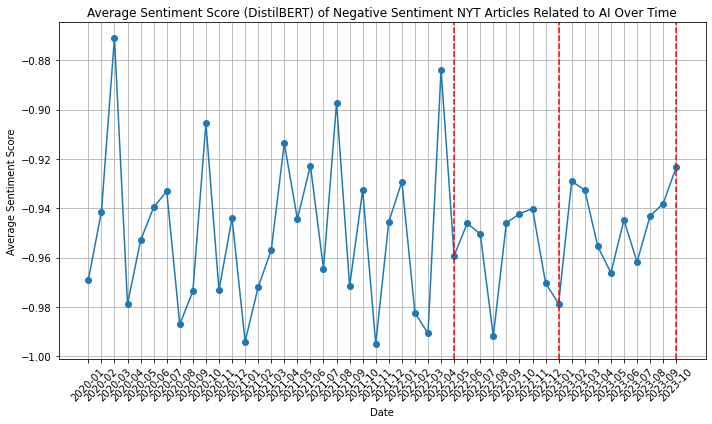

In [66]:
# Filter negative articles
negative_articles = nyt_data[nyt_data['distilbert_sentiment_dummy'] == 0]

# Group by date and calculate average sentiment score
average_sentiment_by_date = negative_articles.groupby('date')['distilbert_sentiment_score'].mean()

# Plot the time-wise graph
plt.figure(figsize=(10, 6))
plt.plot(average_sentiment_by_date.index, average_sentiment_by_date.values, marker='o', linestyle='-')
plt.title('Average Sentiment Score (DistilBERT) of Negative Sentiment NYT Articles Related to AI Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
# Draw a horizontal line at date '2023-01'
plt.axvline(x='2023-01', color='r', linestyle='--', label='2023-01')
plt.axvline(x='2022-05', color='r', linestyle='--', label='2023-01')
plt.axvline(x='2023-10', color='r', linestyle='--', label='2023-11')
plt.show()

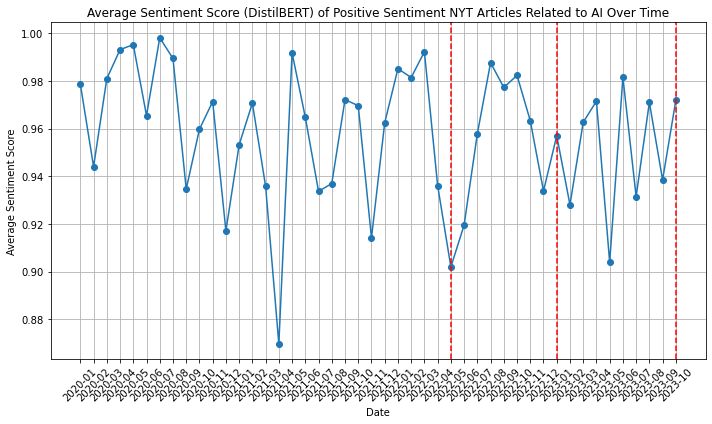

In [67]:
# Filter positive articles
positive_articles = nyt_data[nyt_data['distilbert_sentiment_dummy'] == 1]

# Group by date and calculate average sentiment score
average_sentiment_by_date = positive_articles.groupby('date')['distilbert_sentiment_score'].mean()

# Plot the time-wise graph
plt.figure(figsize=(10, 6))
plt.plot(average_sentiment_by_date.index, average_sentiment_by_date.values, marker='o', linestyle='-')
plt.title('Average Sentiment Score (DistilBERT) of Positive Sentiment NYT Articles Related to AI Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
# Draw a horizontal line at date '2023-01'
plt.axvline(x='2023-01', color='r', linestyle='--', label='2023-01')
plt.axvline(x='2022-05', color='r', linestyle='--', label='2023-01')
plt.axvline(x='2023-10', color='r', linestyle='--', label='2023-11')
plt.show()

### Using Lexicon-Based Methods 

#### Data Cleaning, POS-tagging, Stop Word Removal, Stemming

In [41]:
import re
# create an empty list for clean paragraphs 
cleanparagraph=[]
# for each rows in the df 
for i in range(len(nyt_data)):
    # replace unwanted characters 
    para=str(nyt_data['paragraph'].iloc[i])
    para=para.replace('\r',' ')
    para=para.replace('\n',' ')
    para=para.replace('. ',' ')
    para=para.replace(', ',' ')
    # remove special characters
    para=re.sub('[^A-Za-z]+', ' ', para)
    # lowercase 
    cleanparagraph.append(para.lower())
nyt_data['clean paragraph']= cleanparagraph

In [42]:
nyt_data.head()

,Unnamed: 0,title,abstract,paragraph,date,distilbert_sentiment_score,clean paragraph
0,0,Soon a Robot Will Be Writing This Headline,"In “A World Without Work,” the economist Danie...","A WORLD WITHOUT WORK Technology, Automation, a...",2020-01,0.891256,a world without work technology automation and...
1,1,A.I. Comes to the Operating Room,Images made by lasers and read by computers ca...,Brain surgeons are bringing artificial intelli...,2020-01,0.991159,brain surgeons are bringing artificial intelli...
2,2,Confessions of a Dating Profile,"My boss’s demands were very, very persuasive, ...","My boss’s demands were very, very persuasive, ...",2020-01,0.998428,my boss s demands were very very persuasive ap...
3,3,"Lesson of the Day: ‘The Machines Are Learning,...","In this lesson, students will learn about how ...","Featured Article: “The Machines Are Learning, ...",2020-01,0.984134,featured article the machines are learning and...
4,4,Facebook Says It Will Ban ‘Deepfakes’,The company said it would remove videos altere...,WASHINGTON — Facebook says it will ban videos ...,2020-01,-0.992838,washington facebook says it will ban videos th...


In [63]:
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')

# POS tagger dictionary
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}


def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        if word.lower() not in set(stopwords.words('english')):
            newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist

nyt_data['POS tagged'] = nyt_data['clean paragraph'].apply(token_stop_pos)
nyt_data.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nadya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nadya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Nadya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Nadya\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


,Unnamed: 0,title,abstract,paragraph,date,distilbert_sentiment_score,clean paragraph,mentions_employment,logitlasso predicted employment mentions,POS tagged
0,0,Soon a Robot Will Be Writing This Headline,"In “A World Without Work,” the economist Danie...","A WORLD WITHOUT WORK Technology, Automation, a...",2020-01,0.891256,a world without work technology automation and...,1,1,"[(world, n), (without, None), (work, n), (tech..."
1,1,A.I. Comes to the Operating Room,Images made by lasers and read by computers ca...,Brain surgeons are bringing artificial intelli...,2020-01,0.991159,brain surgeons are bringing artificial intelli...,0,0,"[(brain, n), (surgeons, n), (bringing, v), (ar..."
2,2,Confessions of a Dating Profile,"My boss’s demands were very, very persuasive, ...","My boss’s demands were very, very persuasive, ...",2020-01,0.998428,my boss s demands were very very persuasive ap...,0,0,"[(boss, n), (demands, n), (persuasive, a), (ap..."
3,3,"Lesson of the Day: ‘The Machines Are Learning,...","In this lesson, students will learn about how ...","Featured Article: “The Machines Are Learning, ...",2020-01,0.984134,featured article the machines are learning and...,0,0,"[(featured, v), (article, n), (machines, n), (..."
4,4,Facebook Says It Will Ban ‘Deepfakes’,The company said it would remove videos altere...,WASHINGTON — Facebook says it will ban videos ...,2020-01,-0.992838,washington facebook says it will ban videos th...,0,0,"[(washington, n), (facebook, n), (says, v), (b..."


In [77]:
nltk.download('sentiwordnet')
from nltk.corpus import sentiwordnet as swn
from nltk.stem import WordNetLemmatizer

def sentiwordnetanalysis(pos_data):
    # Initialize WordNetLemmatizer
    wordnet_lemmatizer = WordNetLemmatizer()
    sentiment = 0
    tokens_count = 0
    for word, pos in pos_data:
        if not pos:
            continue
        lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
        if not lemma:
            continue
        synsets = wordnet.synsets(lemma, pos=pos)
        if not synsets:
            continue
        # Take the first sense, the most common
        synset = synsets[0]
        swn_synset = swn.senti_synset(synset.name())
        sentiment += swn_synset.pos_score() - swn_synset.neg_score()
        tokens_count += 1
    if not tokens_count:
        return 0
    else:
        return sentiment 

nyt_data['SWN analysis'] = nyt_data['POS tagged'].apply(sentiwordnetanalysis)

[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\Nadya\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


In [92]:
def normalize_swn_analysis(score):
    # Define the minimum and maximum possible sentiment scores
    min_score = -1.0
    max_score = 1.0
    
    # Perform min-max normalization
    normalized_score = (score - min_score) / (max_score - min_score)
    
    # Clip the normalized score to the range of -1 to +1
    normalized_score = max(min(normalized_score, 1.0), -1.0)
    
    return normalized_score

# Normalize the 'SWN analysis' column
nyt_data['SWN analysis'] = nyt_data['SWN analysis'].apply(normalize_swn_analysis)



In [93]:
nyt_data.head()

,Unnamed: 0,title,abstract,paragraph,date,distilbert_sentiment_score,clean paragraph,mentions_employment,logitlasso predicted employment mentions,POS tagged,SWN analysis
0,0,Soon a Robot Will Be Writing This Headline,"In “A World Without Work,” the economist Danie...","A WORLD WITHOUT WORK Technology, Automation, a...",2020-01,0.891256,a world without work technology automation and...,1,1,"[(world, n), (without, None), (work, n), (tech...",0.75000
1,1,A.I. Comes to the Operating Room,Images made by lasers and read by computers ca...,Brain surgeons are bringing artificial intelli...,2020-01,0.991159,brain surgeons are bringing artificial intelli...,0,0,"[(brain, n), (surgeons, n), (bringing, v), (ar...",1.00000
2,2,Confessions of a Dating Profile,"My boss’s demands were very, very persuasive, ...","My boss’s demands were very, very persuasive, ...",2020-01,0.998428,my boss s demands were very very persuasive ap...,0,0,"[(boss, n), (demands, n), (persuasive, a), (ap...",0.71875
3,3,"Lesson of the Day: ‘The Machines Are Learning,...","In this lesson, students will learn about how ...","Featured Article: “The Machines Are Learning, ...",2020-01,0.984134,featured article the machines are learning and...,0,0,"[(featured, v), (article, n), (machines, n), (...",0.75000
4,4,Facebook Says It Will Ban ‘Deepfakes’,The company said it would remove videos altere...,WASHINGTON — Facebook says it will ban videos ...,2020-01,-0.992838,washington facebook says it will ban videos th...,0,0,"[(washington, n), (facebook, n), (says, v), (b...",0.50000


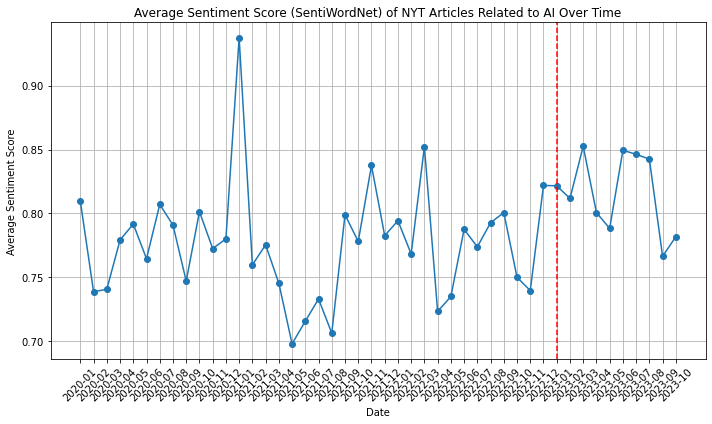

In [94]:
# Group by date and calculate average sentiment score
average_sentiment_by_date = nyt_data.groupby('date')['SWN analysis'].mean()

# Plot the time-wise graph
plt.figure(figsize=(10, 6))
plt.plot(average_sentiment_by_date.index, average_sentiment_by_date.values, marker='o', linestyle='-')
plt.title('Average Sentiment Score (SentiWordNet) of NYT Articles Related to AI Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
# Draw a horizontal line at date '2023-01'
plt.axvline(x='2023-01', color='r', linestyle='--', label='2023-01')
plt.show()

## Other links to employment - which articles mention employment? What are the sentiment paths of these articles? Which words are most predictive of these articles? What are the sentiments of these words?

In [95]:
# Define employment-related keywords
employment_keywords = ['employment', 'jobs', 'job', 'occupation', 'work', 'trade', 'profession']

# Function to check if paragraph contains employment-related keywords
def contains_employment_keywords(paragraph):
    for keyword in employment_keywords:
        if keyword in paragraph:
            return 1
    return 0

# Create dummy variable indicating whether employment-related keywords are mentioned
nyt_data['mentions_employment'] = nyt_data['clean paragraph'].apply(contains_employment_keywords)


In [96]:
employment_mentions_nyt = nyt_data[nyt_data['mentions_employment'] == 1]


In [97]:
employment_mentions_nyt.shape

(159, 11)

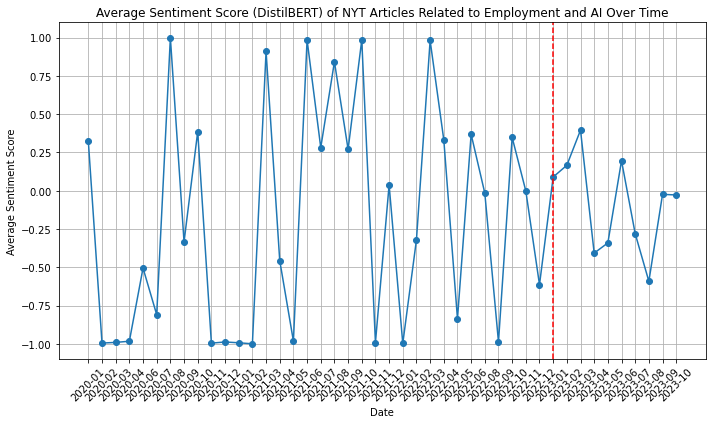

In [98]:
# Group by date and calculate average sentiment score
average_sentiment_by_date = employment_mentions_nyt.groupby('date')['distilbert_sentiment_score'].mean()

# Plot the time-wise graph
plt.figure(figsize=(10, 6))
plt.plot(average_sentiment_by_date.index, average_sentiment_by_date.values, marker='o', linestyle='-')
plt.title('Average Sentiment Score (DistilBERT) of NYT Articles Related to Employment and AI Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
# Draw a horizontal line at date '2023-01'
plt.axvline(x='2023-01', color='r', linestyle='--', label='2023-01')
plt.show()

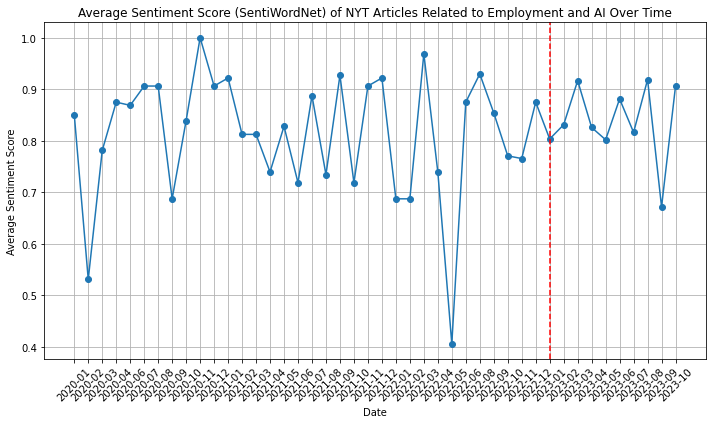

In [99]:
# Group by date and calculate average sentiment score
average_sentiment_by_date = employment_mentions_nyt.groupby('date')['SWN analysis'].mean()

# Plot the time-wise graph
plt.figure(figsize=(10, 6))
plt.plot(average_sentiment_by_date.index, average_sentiment_by_date.values, marker='o', linestyle='-')
plt.title('Average Sentiment Score (SentiWordNet) of NYT Articles Related to Employment and AI Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
# Draw a horizontal line at date '2023-01'
plt.axvline(x='2023-01', color='r', linestyle='--', label='2023-01')
plt.show()

### Logit-lasso regression

In [ ]:
# Do this for sentiment 

In [ ]:
# Scrub explicitly employment related keywords from the data 

In [47]:
vectorizer = TfidfVectorizer()

# Fit and transform the clean paragraph list to create the document-term matrix
X = vectorizer.fit_transform(nyt_data['clean paragraph'])

In [48]:
# Convert binary sentiment column to array y
y = nyt_data['mentions_employment'].to_numpy()

# Convert document term matrix to array X
x = X.toarray() 

In [49]:
features = vectorizer.get_feature_names()

C:\Users\Nadya\anaconda3\envs\ECON1680\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [50]:

# Values of C to consider
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# Initialize variables to store maximum accuracy and corresponding C value
max_accuracy = 0
best_C = None

# Loop over different values of C
for C in C_values:
    # Create and fit the logistic regression model
    model = LogisticRegression(penalty='l1', solver='liblinear', random_state=1680, C=C)
    model.fit(x, y)
    
    # Calculate accuracy
    accuracy = model.score(x, y)
    
    # Check if this accuracy is the highest so far
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        best_C = C

print("Best C value:", best_C)

Best C value: 100


In [51]:
model = LogisticRegression(penalty='l1', solver='liblinear', random_state=1680, C=best_C)
model.fit(x, y)

# Save model coefficients as "coefs"
coefs = model.coef_

In [52]:
# create a new dataframe with words and their assigned coefficients 
df_coef = pd.DataFrame({'word': features, 'coef': coefs[-1].tolist()}) 
# absolute value of coefficients 
df_coef['abs coef']= df_coef['coef'].abs()
# use logistic regression to predict mentions of employment
nyt_data['logitlasso predicted employment mentions'] = model.predict(x)

In [56]:
# Sort DataFrame by absolute values of coefficients
df_coef_sorted = df_coef.sort_values(by='abs coef', ascending=False)

# Get top 50 most predictive words of mentions of employment
df_coef_sorted.head(50)

,word,coef,abs coef
8891,work,120.625422,120.625422
4266,job,85.725031,85.725031
8895,working,81.623768,81.623768
8894,workers,79.862922,79.862922
8172,trade,78.393113,78.393113
5274,network,76.338704,76.338704
4267,jobs,70.468350,70.468350
8381,unemployment,68.539217,68.539217
5276,networks,52.546593,52.546593
8898,works,51.596333,51.596333
